# Proyecto: Flask-Render Integration

## Importar librerías

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from xgboost import plot_importance
import pickle
import os

## Cargar dataset

In [22]:
# Cargar el archivo CSV
df = pd.read_csv("C:/Users/Efrain Almeida/Documents/4Geeks Academy/02 Proyectos/efrainnalmeida-flask-render-integration/data/car_evaluation.csv")

## EDA

In [23]:
# Vista general del dataframe
df_info = df.info()
df_head = df.head()
df_description = df.describe(include='all').T

(df_info, df_head, df_description)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


(None,
   buying  maint doors persons lug_boot safety  class
 0  vhigh  vhigh     2       2    small    low  unacc
 1  vhigh  vhigh     2       2    small    med  unacc
 2  vhigh  vhigh     2       2    small   high  unacc
 3  vhigh  vhigh     2       2      med    low  unacc
 4  vhigh  vhigh     2       2      med    med  unacc,
          count unique    top  freq
 buying    1728      4  vhigh   432
 maint     1728      4  vhigh   432
 doors     1728      4      2   432
 persons   1728      3      2   576
 lug_boot  1728      3  small   576
 safety    1728      3    low   576
 class     1728      4  unacc  1210)

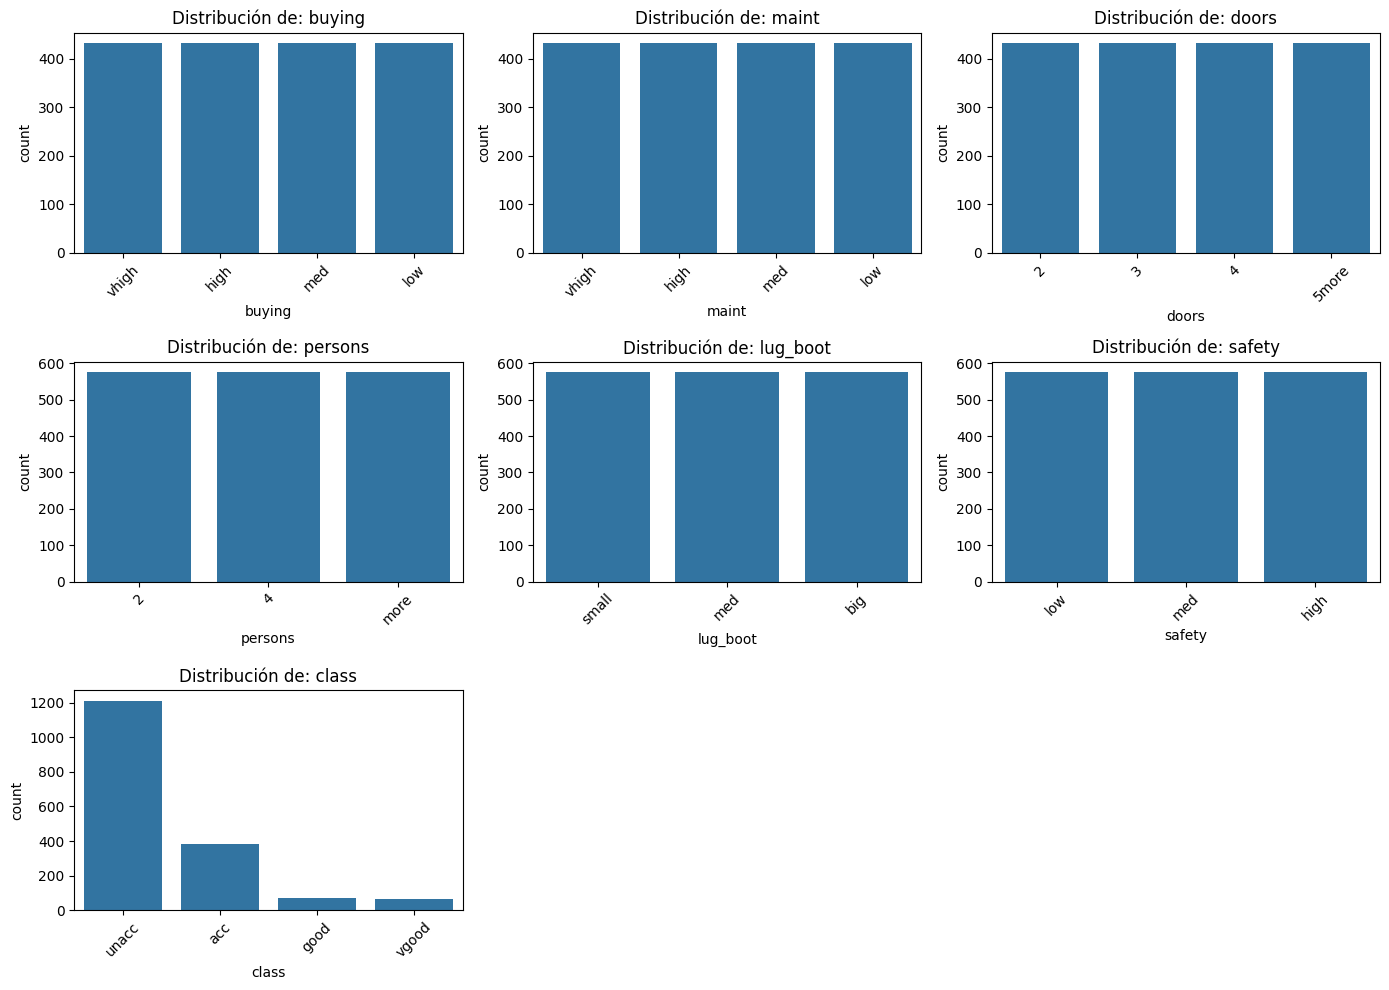

In [24]:
# Gráfico de frecuencia por variable

# Ajustar el tamaño de los gráficos
plt.figure(figsize=(14, 10))

# Crear un gráfico de barras para cada variable categórica
categorical_columns = df.columns.tolist()

# Crear subplots dinámicamente
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(3, 3, i)
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f'Distribución de: {col}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

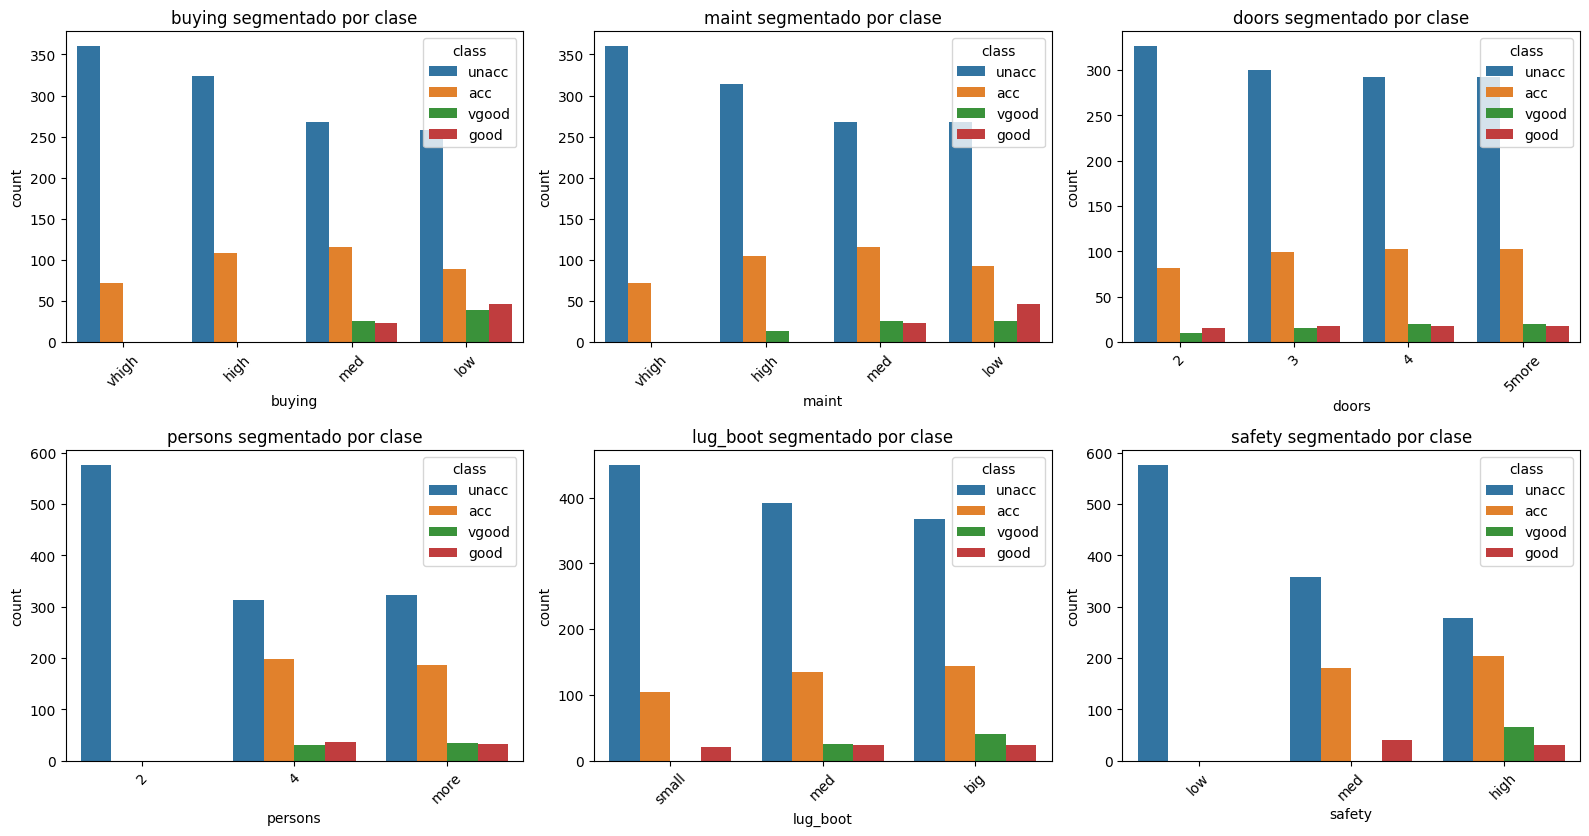

In [25]:
# # Gráfico de frecuencia por variable, segmentado por clase

# Ajustar el tamaño de los gráficos
plt.figure(figsize=(16, 12))

# Crear un gráfico de barras segmentado por clase para cada feature
for i, col in enumerate(df.columns[:-1], 1):  # excluir la columna 'class'
    plt.subplot(3, 3, i)
    sns.countplot(data=df, x=col, hue="class", order=df[col].value_counts().index)
    plt.title(f'{col} segmentado por clase')
    plt.xticks(rotation=45)
    plt.legend(title='class', loc='best')

plt.tight_layout()
plt.show()

In [26]:
# Crear copia del DataFrame para codificación
df_encoded = df.copy()

# Aplicar codificación LabelEncoder a todas las columnas categóricas
label_encoders = {}
for col in df_encoded.columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le  # Guardar el codificador por si se necesita revertir

# Separar features y target codificados
X_encoded = df_encoded.drop("class", axis=1)
y_encoded = df_encoded["class"]

print(X_encoded.head())
print(y_encoded.head())

   buying  maint  doors  persons  lug_boot  safety
0       3      3      0        0         2       1
1       3      3      0        0         2       2
2       3      3      0        0         2       0
3       3      3      0        0         1       1
4       3      3      0        0         1       2
0    2
1    2
2    2
3    2
4    2
Name: class, dtype: int64


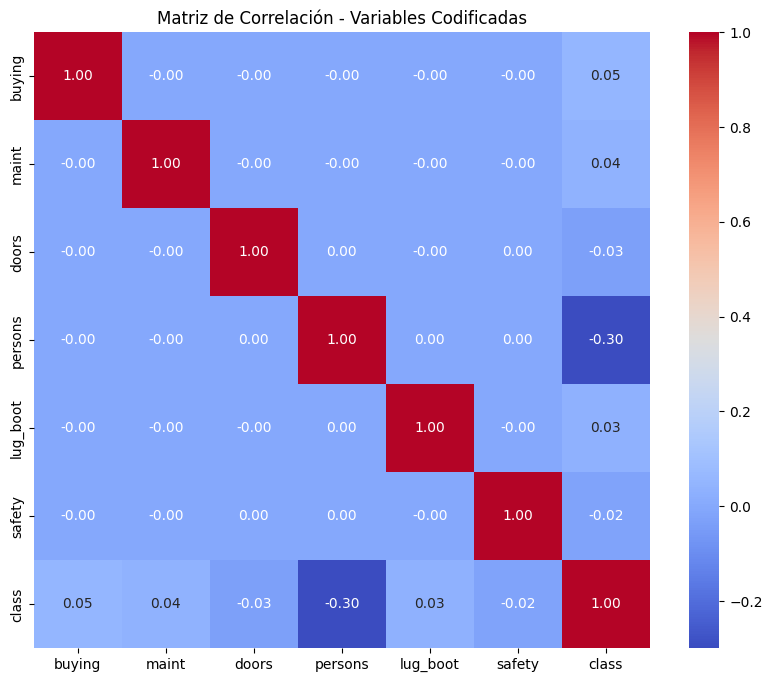

In [27]:
# Calcular la matriz de correlación
corr_matrix = df_encoded.corr(numeric_only=True)

# Configurar el gráfico
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Matriz de Correlación - Variables Codificadas")
plt.show()

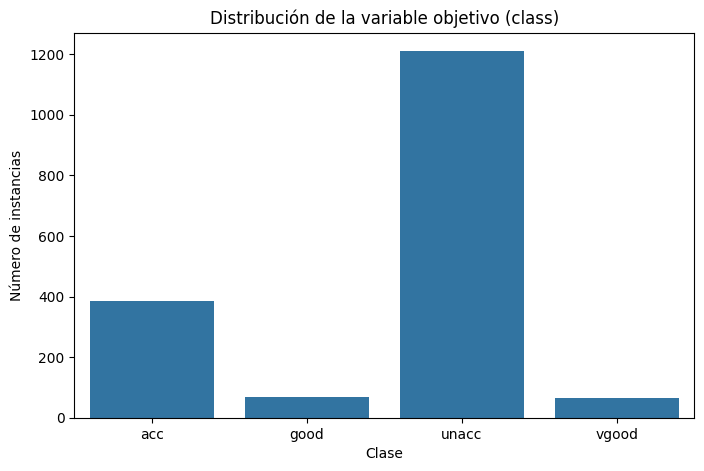

class
0    0.222222
1    0.039931
2    0.700231
3    0.037616
Name: count, dtype: float64

In [28]:
# Análisis del desbalance en la variable objetivo

# Contar la frecuencia de cada clase
class_counts = y_encoded.value_counts().sort_index()

# Obtener etiquetas originales con el codificador
class_labels = label_encoders["class"].inverse_transform(class_counts.index)

# Visualizar el desbalance
plt.figure(figsize=(8, 5))
sns.barplot(x=class_labels, y=class_counts.values)
plt.title("Distribución de la variable objetivo (class)")
plt.xlabel("Clase")
plt.ylabel("Número de instancias")
plt.show()

# Mostrar proporciones
class_proportions = class_counts / class_counts.sum()
class_proportions

## XGBoost Classifier

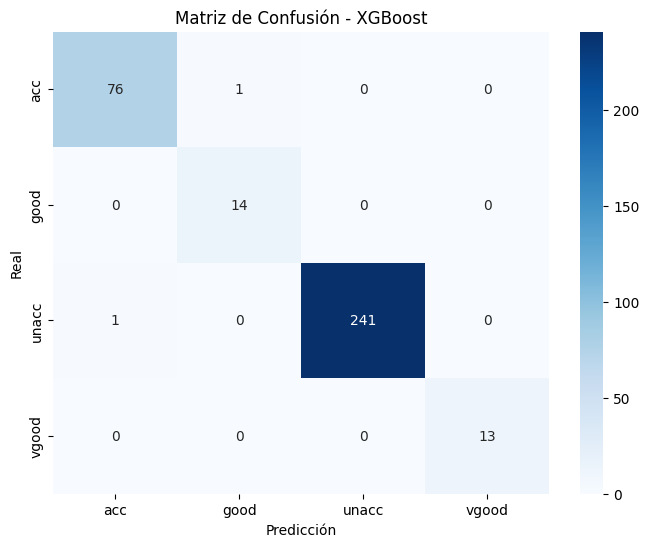

,precision,recall,f1-score,support
acc,0.987013,0.987013,0.987013,77.00000
good,0.933333,1.000000,0.965517,14.00000
unacc,1.000000,0.995868,0.997930,242.00000
vgood,1.000000,1.000000,1.000000,13.00000
accuracy,0.994220,0.994220,0.994220,0.99422
macro avg,0.980087,0.995720,0.987615,346.00000
weighted avg,0.994412,0.994220,0.994266,346.00000


In [29]:
# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Calcular pesos de muestra para entrenamiento
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Inicializar el modelo XGBoost para clasificación multiclase
xgb_model = XGBClassifier(
    objective='multi:softprob',
    num_class=4,
    eval_metric='mlogloss',
    random_state=42
)

# Entrenar el modelo con pesos
xgb_model.fit(X_train, y_train, sample_weight=sample_weights)

# Predicciones
y_pred = xgb_model.predict(X_test)

# Evaluación
report = classification_report(y_test, y_pred, target_names=label_encoders["class"].classes_, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoders["class"].classes_, yticklabels=label_encoders["class"].classes_)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - XGBoost")
plt.show()

pd.DataFrame(report).T

In [30]:
# Obtener probabilidades
y_proba = xgb_model.predict_proba(X_test)

# Calcular AUC One-vs-Rest
auc_ovr = roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted')
print(f"AUC OvR (weighted): {auc_ovr:.4f}")

AUC OvR (weighted): 1.0000


<Figure size 1000x600 with 0 Axes>

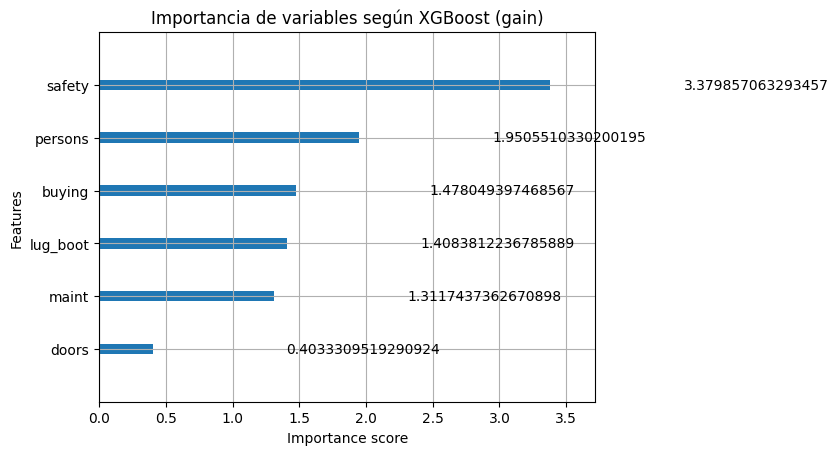

In [36]:
# Visualizar la importancia de las variables (por ganancia promedio)
plt.figure(figsize=(10, 6))
plot_importance(xgb_model, importance_type='gain', max_num_features=10)
plt.title("Importancia de variables según XGBoost (gain)")
plt.show()

## Guardar el modelo

In [40]:
# Ruta de salida
output_path = r"C:/Users/Efrain Almeida/Documents/4Geeks Academy/02 Proyectos/efrainnalmeida-flask-render-integration/models"

# Guardar el modelo
with open(os.path.join(output_path, "xgb_model.pkl"), "wb") as f:
    pickle.dump(xgb_model, f)

# Guardar los LabelEncoders
with open(os.path.join(output_path, "label_encoders.pkl"), "wb") as f:
    pickle.dump(label_encoders, f)

# Guardar el orden de las columnas
with open(os.path.join(output_path, "feature_order.pkl"), "wb") as f:
    pickle.dump(X_encoded.columns.tolist(), f)

print("✅ Archivos guardados exitosamente en la carpeta 'models'.")

✅ Archivos guardados exitosamente en la carpeta 'models'.
